# Panel 2

### `import packages.needed`

In [1]:
%matplotlib inline
#
from lrgsglib.shared import *
from lrgsglib.config.const import *
from lrgsglib.config.plotlib import restr_twilight, cblu, cred, \
    inset_axes, set_ax_ratio_1_withlim, create_custom_colormap, \
    scheme_Lattice2DSquared, plot_evolving_grid_rw
from lrgsglib.config.utils import find_shared_p_values, move_to_rootf, \
    unzip_dict_items, find_matching_files, extract_values_from_filenames
from lrgsglib.core import Lattice2D, Lattice3D, \
    flip_to_positive_majority_adapted
#
from matplotlib.colors import LightSource
from mpl_toolkits.mplot3d import Axes3D
#
move_to_rootf()
plt.style.use('ipynb/nb_plotsheet.mplstyle')
#
subDatPth = os.path.join('plot', 'paper', 'panel_2', '')
datPth = os.path.join('data', subDatPth)
subPthStr = ['evolving_grid_rw', 'lattices', 'eigV', 'Squared', 
                 'Triangular', '3D', 'Hexagonal', 'pCluster']
datPthDict = {s: os.path.join(datPth, s, '') for s in subPthStr}
for path in datPthDict.values(): os.makedirs(path, exist_ok=True)
#
axvline_kwarg = dict(ls=':', color='k')
xlabelinset_kwargs = dict(labelpad=0, fontsize=18)
ylabelinset_kwargs = dict(rotation=90, labelpad=10, va="center",fontsize=18)
axins_tickparams_kwargs = dict(axis='both', which='major', size=7, width=1.25, 
                               labelsize=16)
axlegend_kwargs = dict(ncol=1, loc='lower left', fontsize=18)
#
kwargs_lines = dict(lw=5, marker='')
kwargs_lines_inset = dict(lw=2, marker='')
cmap = restr_twilight

Current working directory: /home/opisthofulax/PhD/projects/complex-networks/lrgsglib


## Fig 01: eigV

### (a): Squared lattice

In [2]:
side = 96
plist = [0.005, 0.0075, 0.01, 0.051, 0.07, 0.09, 0.103, 0.12, 0.206, 0.412]

In [3]:
arr_list = []
for pfl in plist:
    filep = f"{datPthDict['lattices']}N={side}_p={pfl:.3g}.npy"
    if os.path.exists(filep):
        arr = np.load(filep)
    else:
        opts = dict(side1 = side, geo = 'squared', pflip = pfl)
        lattice = Lattice2D(**opts)
        lattice.flip_random_fract_edges()
        lattice.compute_k_eigvV()
        arr = lattice.eigV[0].reshape(lattice.syshape)
        np.save(filep, arr)
    arr_list.append(arr)

In [4]:
for idx in range(len(plist)):
    fppath = f"{datPthDict['eigV']}/_N={side}_p={plist[idx]:.3g}.pdf"
    fig, ax = plt.subplots(figsize=(8, 8))
    if np.sign(arr_list[idx]).sum() > 0:
        cmap = create_custom_colormap(c1=cblu, c2=cred)
    else:
        cmap = create_custom_colormap(c1=cblu, c2=cred)
    im = ax.imshow(flip_to_positive_majority_adapted(np.sign(arr_list[idx])), 
                   cmap=cmap, interpolation='None', rasterized=False)
    ax.axis('off')
    fig.savefig(fppath, bbox_inches='tight', transparent=True, pad_inches=0)
    plt.close('all')

### (b): Cubic lattice

In [5]:
side = 20
pflip = 0.5
fppath = f"{datPthDict['eigV']}/3D_N={side**3}_p={pflip:.3g}.pdf"

In [6]:
l = Lattice3D(dim=(side, side, side), pflip=pflip)
l.flip_random_fract_edges()
l.compute_k_eigvV()
l.load_eigV_on_graph(binarize=True)
G_pos, G_neg = l.group_nodes_by_kv(f"eigV0", -1)
clusters = sorted(list(nx.connected_components(G_neg)),  key=lambda x: len(x), reverse=True)
clusterLen = list(map(lambda x: len(x), clusters))
# print(np.log10(np.abs(l.eigV[0])).min(), np.log10(np.abs(l.eigV[0])).max(), sep='\n')

In [7]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
#
ax.view_init(elev=25, azim=45)
lightsource = LightSource(altdeg=20, azdeg=90)
#
ax.set_axis_off()
ax.set_aspect('equal')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
#
voxel_array = np.zeros((side, side, side), dtype=bool)
points_array = np.array(list(G_neg.nodes()))
voxel_array[tuple(points_array.T)] = True
#
notvoxel = np.logical_not(voxel_array)
height_to_remove = side // 2
notvoxel[:, :, -height_to_remove:] = False 
ax.voxels(notvoxel,
        facecolors=cred,
        lw=0.2,
        alpha=.5,
        edgecolor='k',
        zorder=0, lightsource=lightsource)
#
ax.voxels(voxel_array,
        facecolors=cblu,
        lw=0.2,
        edgecolor='k',
        zorder=0, lightsource=lightsource)
# for i, cc in enumerate(clusters):
#     voxel_array = np.zeros((side, side, side), dtype=bool)
#     points_array = np.array(list(cc))
#     voxel_array[tuple(points_array.T)] = True
#     # print(np.exp(-len(cc)/len(clusters[0])))
#     nd2col = 1-np.log(len(cc))/np.log(len(clusters[0]))
#     facecolor = (nd2col, nd2col, 1, 1)
#     ax.voxels(voxel_array,
#             facecolors=facecolor,
#             lw=0.2,
#             edgecolor='k',
#             zorder=0, lightsource=lightsource)

x = [0, 0, side]
y = [side, 0, 0]
z = [0, 0, 0]
ax.plot3D(x, y, np.full(len(x), 0), c='k', marker='', zorder=0)
x = [side, side, 0]
y = [0, side, side]
z = [0, 0, 0]
ax.plot3D(x, y, np.full(len(x), 0), c='k', marker='', zorder=l.N)
x = [0, side, side, 0, 0]
y = [0, 0, side, side, 0]
z = [0, 0, 0, 0, 0]
ax.plot3D(x, y, np.full(len(x), side), c='k', marker='', zorder=l.N)
for i in range(4):
    ax.plot3D([x[i], x[i]], [y[i], y[i]], [z[i], side], c='k', 
              marker='', zorder=l.N if i > 0 else 0)
fig.savefig(fppath, bbox_inches='tight', transparent=True, pad_inches=0)
plt.close('all')

## Fig 02: 2D

### (c): Cluster $P_{\infty}$ and $\chi$

In [46]:
sides = [16, 32, 64, 128]
navg = 10000
#
colors = cmap(np.linspace(0, 1, len(sides)))
# Set these colors as the default color cycle
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=colors)


In [47]:
fig, ax = plt.subplots(figsize=(8, 8))
axins = inset_axes(ax, width="100%", height="100%", bbox_to_anchor=(0.62, 0.62, 0.35, 0.35), loc='upper right', bbox_transform=ax.transAxes)

for cc, side in enumerate(sides):
    l = Lattice2D(side, init_nw_dict=False, with_positions=False)
    fname = f"data/plot/paper/suppinf/data_pablo_2-3-4-D/OP_Squared_L{side}"
    data = np.loadtxt(fname, delimiter=',')
    p = data[:, 9]
    p_c = data[np.argmax(data[:, 1]), 9]
    S = gaussian_filter(data[:, 0], sigma=1)
    sigmaS = gaussian_filter(data[:, 1], sigma=1)
    L = side
    # plt.plot(p, S, label=f'L={side}', lw=2)
    ax.plot(p, S, label=fr'${l.N}$', zorder=1/(cc+1), **kwargs_lines)
    axins.plot(p, sigmaS*L, zorder=1/(cc+1), **kwargs_lines_inset)
#
# ax[0].axhline(0.5, ls='--', c='k')
#
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$P_{\infty}$')
#
ax.text(0.82, 0.85, r'\textbf{(c)}', transform=ax.transAxes, fontsize=40,
                 fontweight='bold', color='black')
ax.legend(fontsize=24, loc='lower left')

# #
axins.axvline(0.1, ls='--', c='k')
axins.set_yticks([])
axins.tick_params(axis='x', labelsize=24)  # Change the font size as needed

axins.set_ylabel(r'$\chi$', fontsize=24)
axins.set_xlabel(r'$p$', fontsize=24, labelpad=0)
axins.set_position([0.5, 0.4, 0.3, 0.3])
# #
fig.savefig(os.path.join(datPth, 'phtra',
                            f'squared_na={navg}.pdf'), bbox_inches='tight',
            transparent=True)
plt.close('all')

### Size distribution at $P(S, p)$

In [ ]:
sideList = [16, 32, 64, 96, 128]
exponent = -1.75
navg = 10000
cell = 'rand'

In [ ]:
l = Lattice2D(sideList[0], sgpath=os.path.join(subDatPth, 'pCluster_new', ''))
fnames = [l.lrgsgpath + s for s in os.listdir(l.lrgsgpath)]
pList = extract_values_from_filenames(fnames, r"p=([\d.]+)")

In [ ]:
storage = {}
for pflip in pList:
    storage[pflip] = {}
    for side in sideList:
        l = Lattice2D(side, sgpath=os.path.join(subDatPth, 'pCluster_new', ''))
        try:
            fname = os.path.join(l.lrgsgpath, 
                                f"pCluster_p={pflip:.3g}_{cell}_na={navg}.pkl")
            with open(fname, 'rb') as f:
                data = pk.load(f)
        except FileNotFoundError:
            effFname = find_matching_files(l.lrgsgpath, 
                                        f"pCluster_p={pflip:.3g}_{cell}")[0]
            if effFname:
                fname = os.path.join(l.lrgsgpath, effFname)
                with open(fname, 'rb') as f:
                    data = pk.load(f)
            else:
                continue
        k, v = unzip_dict_items(data)
        arr = np.repeat(k, v)
        x, pdf = powerlaw.pdf(arr, xmin=1)
        storage[pflip][side] = [x[1:], pdf]
        #
    fig, ax = plt.subplots(figsize=(6*1.5, 5*1.5))
    #
    for k, v in storage[pflip].items():
        ax.loglog(v[0], v[1],  lw=2*k**(1/4), marker='', zorder=1/k, 
                    label=fr"$\underset{{{{\scriptscriptstyle L={k}}}}}{{{k**2}}}$")
    xx, yy = x[1:], x[1:]**(exponent)
    ax.loglog(xx, yy, ls='--', color='k', lw=3, marker='')
    #
    ax.legend(fontsize=26, ncols=2, columnspacing=0.5)
    ax.set_xlabel(r"$S$")
    ax.set_ylabel(r"$P(S)$")
    fig.tight_layout()
    fig.savefig(os.path.join(datPth, 'pCluster_new', 
                             f'pCluster2D_p={pflip:.3g}_{cell}_na={navg}.pdf'), 
                bbox_inches='tight')
    plt.close('all')

### (d) Size distribution at $P(S, p_{\rm c, fss})$

In [33]:
sideList = [16, 32, 64, 96, 128]
pList = [0.153, 0.113, 0.105, 0.0895,  0.0895]
exponent = -1.75
navg = 10000
cell = 'rand'
colors = cmap(np.linspace(0.0, 1, len(sideList)))
# Set these colors as the default color cycle
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=colors)

In [34]:

storage = {}
alpha = []
dList = []
for side, pflip in zip(sideList, pList):
    storage[side] = {}
    l = Lattice2D(side, sgpath=os.path.join(subDatPth, 'pCluster_new', ''))
    try:
        fname = os.path.join(l.lrgsgpath, 
                            f"pCluster_p={pflip:.3g}_{cell}_na={navg}.pkl")
        with open(fname, 'rb') as f:
            data = pk.load(f)
    except FileNotFoundError:
        effFname = find_matching_files(l.lrgsgpath, 
                                    f"pCluster_p={pflip:.3g}_{cell}")[0]
        if effFname:
            fname = os.path.join(l.lrgsgpath, effFname)
            with open(fname, 'rb') as f:
                data = pk.load(f)
        else:
            continue
    k, v = unzip_dict_items(data)
    arr = np.repeat(k, v)
    fit = powerlaw.Fit(arr, xmin=10)
    alpha.append(fit.power_law.alpha)
    dList.append(fit.power_law.D)
    x, pdf = powerlaw.pdf(arr, xmin=1)
    storage[side] = [x[1:], pdf]
    #
fig, ax = plt.subplots(figsize=(7*1.5, 5*1.5))
#
for i, (k, v) in enumerate(storage.items()):
    label = fr"$\underset{{{{\scriptstyle p={pList[i]:.3g}}}}}{{L={k}}}$"
    ax.loglog(v[0], v[1],  lw=6, marker='', zorder=1/k, 
                label=label)
# exponent = -np.mean(alpha)
# xx, yy = x[1:], x[1:]**(exponent)
# label = fr"$\propto S^{{{exponent:.3g}}}$"
# ax.loglog(xx, yy, ls='--', color='k', lw=3 , marker='', label=label)
xx, yy = v[0], 0.2*v[0]**(exponent)
label = fr"$\propto S^{{{exponent:.2g}}}$"
ax.loglog(xx, yy, ls='--', color='k', lw=3 , marker='', label=label)
# ax.loglog(x, 0.2*x**(-fit.alpha), ls='--', color='k', lw=3, marker='')
#
ax.text(0.9, 0.9, r'\textbf{(d)}', transform=ax.transAxes, fontsize=40,
                 fontweight='bold', color='black')
ax.legend(fontsize=24, ncols=2, columnspacing=0.5, loc='lower left')
ax.set_xlabel(r"$S$")
ax.set_ylabel(r"$P(S)$")
fig.tight_layout()
fig.savefig(os.path.join(datPth, 'pCluster_new', 
                            f'pCluster2D_total_{cell}_na={navg}.pdf'), 
            bbox_inches='tight', transparent=True)
plt.close('all')

/home/opisthofulax/anaconda3/envs/lrgsgenv/lib/python3.12/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


## Fig 03: 3D

### (e): Cluster $P_{\infty}$ and $\chi$

In [24]:
sides = [8, 13, 16, 20, 30, 40]
navg = 10000
#
colors = cmap(np.linspace(0.0, 1, len(sides)))
# Set these colors as the default color cycle
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=colors)


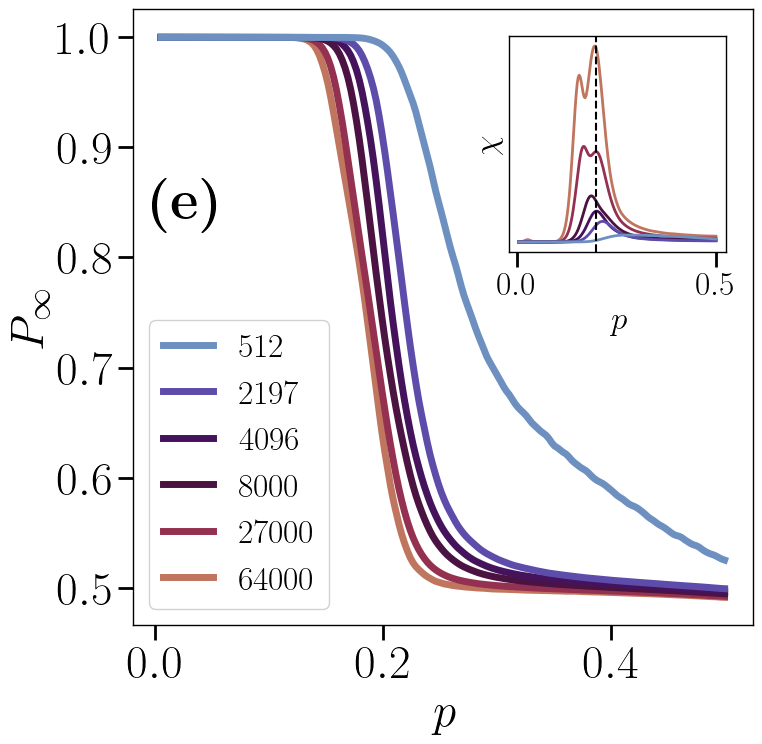

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))
axins = inset_axes(ax, width="100%", height="100%", bbox_to_anchor=(0.62, 0.62, 0.35, 0.35), loc='upper right', bbox_transform=ax.transAxes)

for cc, side in enumerate(sides):
    l = Lattice3D(side, init_nw_dict=False, with_positions=False)
    fname = f"data/plot/paper/suppinf/data_pablo_2-3-4-D/OP_Squared3D_L{side}"
    data = np.loadtxt(fname, delimiter=',')
    p = data[:, 9]
    p_c = data[np.argmax(data[:, 1]), 9]
    S = gaussian_filter(data[:, 0], sigma=1)
    sigmaS = gaussian_filter(data[:, 1], sigma=3)
    L = side
    # plt.plot(p, S, label=f'L={side}', lw=2)
    ax.plot(p, S, label=fr'${l.N}$', zorder=1/(cc+1), **kwargs_lines)
    axins.plot(p, sigmaS*l.N, zorder=1/(cc+1), **kwargs_lines_inset)
#
# ax[0].axhline(0.5, ls='--', c='k')
#
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$P_{\infty}$')
#
ax.text(0.03, 0.66, r'\textbf{(e)}', transform=ax.transAxes, fontsize=40,
                 fontweight='bold', color='black')
ax.legend(fontsize=24, loc='lower left')

# #
axins.axvline(0.2, ls='--', c='k')
axins.set_yticks([])
axins.tick_params(axis='x', labelsize=24)  # Change the font size as needed

axins.set_ylabel(r'$\chi$', fontsize=24)
axins.set_xlabel(r'$p$', fontsize=24)
axins.set_position([0.5, 0.4, 0.3, 0.3])
# #
fig.savefig(os.path.join(datPth, 'phtra',
                            f'3D_na={navg}.pdf'), bbox_inches='tight',
            transparent=True)
plt.close('all')

### (f): Size distribution at $P(S, p_{\rm c, fss})$

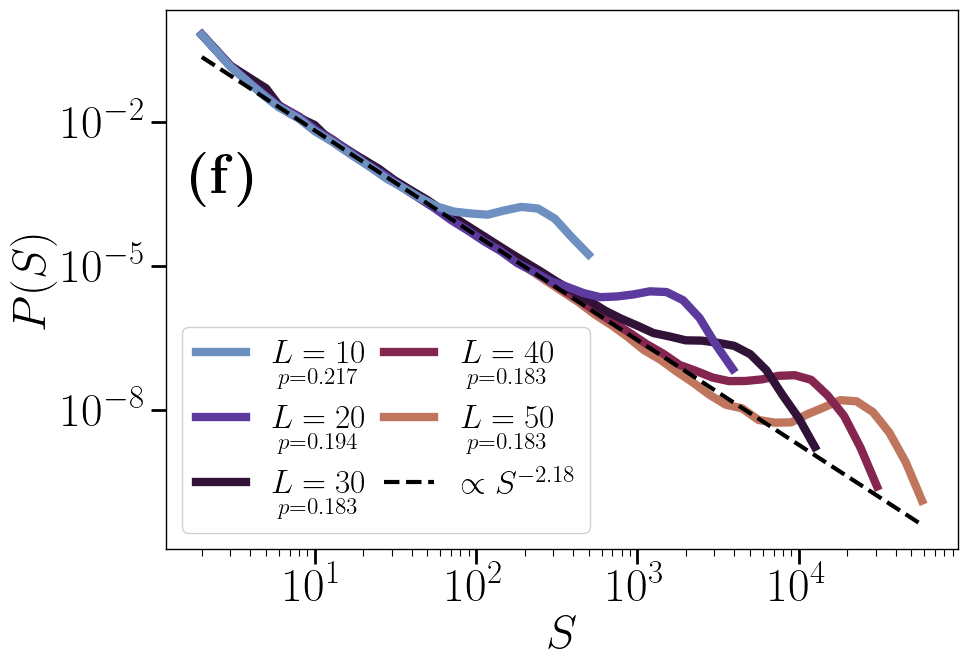

In [27]:
sideList = [10, 20, 30, 40, 50]
pList = [0.217, 0.194, 0.183, 0.183, 0.183]
cell= 'rand'
exponent = -2.18
colors = cmap(np.linspace(0.0, 1, len(pList)))
# Set these colors as the default color cycle
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=colors)
storage = {}
for side, pflip in zip(sideList, pList):
    storage[side] = {}
    l = Lattice3D(side, sgpath=os.path.join(subDatPth, 'pCluster_new', ''))
    try:
        fname = os.path.join(l.lrgsgpath, 
                            f"pCluster_p={pflip:.3g}_{cell}_na={navg}.pkl")
        with open(fname, 'rb') as f:
            data = pk.load(f)
    except FileNotFoundError:
        effFname = find_matching_files(l.lrgsgpath, 
                                    f"pCluster_p={pflip:.3g}_{cell}")[0]
        if effFname:
            fname = os.path.join(l.lrgsgpath, effFname)
            with open(fname, 'rb') as f:
                data = pk.load(f)
        else:
            continue
    k, v = unzip_dict_items(data)
    arr = np.repeat(k, v)
    x, pdf = powerlaw.pdf(arr, xmin=1)
    storage[side] = [x[1:], pdf]
    #
fig, ax = plt.subplots(figsize=(7*1.5, 5*1.5))
#
for i, (k, v) in enumerate(storage.items()):
    label = fr"$\underset{{{{\scriptstyle p={pList[i]:.3g}}}}}{{L={k}}}$"
    ax.loglog(v[0], v[1],  lw=6, marker='', zorder=1/k, 
                label=label)
xx, yy = x[1:], x[1:]**(exponent)
label = fr"$\propto S^{{{exponent}}}$"
ax.loglog(xx, yy, ls='--', color='k', lw=3 , marker='', label=label)
#
ax.text(0.03, 0.66, r'\textbf{(f)}', transform=ax.transAxes, fontsize=40,
                 fontweight='bold', color='black')
ax.legend(fontsize=24, ncols=2, columnspacing=0.5)
ax.set_xlabel(r"$S$")
ax.set_ylabel(r"$P(S)$")
fig.tight_layout()
fig.savefig(os.path.join(datPth, 'pCluster_new', 
                            f'pCluster3D_total_{cell}_na={navg}.pdf'), 
            bbox_inches='tight', transparent=True)
plt.close('all')

### Size distribution at $P(S, p)$

In [ ]:
sideList = [5, 10, 20, 30, 40, 50]
exponent = -2.18
navg = 10000
cell = 'rand'
l = Lattice3D(sideList[0], sgpath=os.path.join(subDatPth, 'pCluster_new', ''))
fnames = [l.lrgsgpath + s for s in os.listdir(l.lrgsgpath)]
pList = extract_values_from_filenames(fnames, r"p=([\d.]+)")

In [ ]:
storage = {}
for pflip in pList:
    storage[pflip] = {}
    for side in sideList:
        l = Lattice3D(side, sgpath=os.path.join(subDatPth, 'pCluster_new', ''))
        try:
            fname = os.path.join(l.lrgsgpath, 
                                f"pCluster_p={pflip:.3g}_{cell}_na={navg}.pkl")
            with open(fname, 'rb') as f:
                data = pk.load(f)
        except FileNotFoundError:
            effFname = find_matching_files(l.lrgsgpath, 
                                        f"pCluster_p={pflip:.3g}_{cell}")[0]
            if effFname:
                fname = os.path.join(l.lrgsgpath, effFname)
                with open(fname, 'rb') as f:
                    data = pk.load(f)
            else:
                continue
        k, v = unzip_dict_items(data)
        arr = np.repeat(k, v)
        x, pdf = powerlaw.pdf(arr, xmin=1)
        storage[pflip][side] = [x[1:], pdf]
        #
    fig, ax = plt.subplots(figsize=(6*1.5, 5*1.5))
    #
    for k, v in storage[pflip].items():
        ax.loglog(v[0], v[1],  lw=2*k**(1/4), marker='', zorder=1/k, 
                    label=fr"$\underset{{{{\scriptscriptstyle L={k}}}}}{{{k**3}}}$")
    xx, yy = x[1:], x[1:]**(exponent)
    ax.loglog(xx, yy, ls='--', color='k', lw=3, marker='')
    #
    ax.legend(fontsize=26, ncols=2, columnspacing=0.5)
    ax.set_xlabel(r"$S$")
    ax.set_ylabel(r"$P(S)$")
    fig.tight_layout()
    fig.savefig(os.path.join(datPth, 'pCluster_new', 
                             f'pCluster3D_p={pflip:.3g}_{cell}_na={navg}.pdf'), 
                bbox_inches='tight')
    plt.close('all')

## Fig. 04(g): grid defects

In [48]:
fig, ax = plt.subplots(figsize=(6, 6))
#
ax.axis("off")
ax.set_aspect('equal')
#
scheme_Lattice2DSquared(ax, 5, 5, cpec=cblu, pec=cred, mode='defects')

ax.text(0.01, 0.86, r'\textbf{(g)}', transform=ax.transAxes, fontsize=40,
                 fontweight='bold', color='black')
#
fig.savefig(f"{datPth}square_defects.pdf", 
            bbox_inches='tight', transparent=True)
plt.close('all')

## Fig. 05: X/Z errors

### (h): Cluster $P_{\infty}$ and $\chi$ ZERR

In [50]:
sides = [16, 32, 64, 96]
navg = 10000
#
colors = cmap(np.linspace(0, 1, len(sides)))
# Set these colors as the default color cycle

In [42]:
fig, ax = plt.subplots(figsize=(8, 8))
axins = inset_axes(ax, width="100%", height="100%", bbox_to_anchor=(0.62, 0.62, 0.35, 0.35), loc='upper right', bbox_transform=ax.transAxes)

plt.rcParams["axes.prop_cycle"] = plt.cycler(color=colors)
for cc, side in enumerate(sides):
    l = Lattice2D(side, init_nw_dict=False, with_positions=False)
    fname = f"data/plot/paper/suppinf/data_pablo_tri-hex/OP_Zerr_Squared_L{side}"
    data = np.loadtxt(fname, delimiter=',')
    p = data[:, 9]
    p_c = data[np.argmax(data[:, 1]), 9]
    S = gaussian_filter(data[:, 0], sigma=1)
    sigmaS = gaussian_filter(data[:, 1], sigma=1)
    L = side
    # plt.plot(p, S, label=f'L={side}', lw=2)
    ax.plot(p, S, label=fr'${l.N}$', zorder=1/(cc+1), **kwargs_lines)
    axins.plot(p, sigmaS*L, zorder=1/(cc+1), **kwargs_lines_inset)
#
# ax[0].axhline(0.5, ls='--', c='k')
#
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$P_{\infty}$')
#
ax.text(0.82, 0.85, r'\textbf{(h)}', transform=ax.transAxes, fontsize=40,
                 fontweight='bold', color='black')
ax.legend(fontsize=24, loc='lower left')

# #
axins.axvline(0.1, ls='--', c='k')
axins.set_yticks([])
axins.tick_params(axis='x', labelsize=24)  # Change the font size as needed

axins.set_ylabel(r'$\chi$', fontsize=24)
axins.set_xlabel(r'$p$', fontsize=24, labelpad=0)
axins.set_position([0.5, 0.4, 0.3, 0.3])
# #
fig.savefig(os.path.join(datPth, 'phtra',
                            f'squaredZERR_na={navg}.pdf'), bbox_inches='tight',
            transparent=True)
plt.close('all')

### (i): Cluster $P_{\infty}$ and $\chi$ XERR

In [55]:
fig, ax = plt.subplots(figsize=(8, 8))
axins = inset_axes(ax, width="100%", height="100%", bbox_to_anchor=(0.62, 0.62, 0.35, 0.35), loc='upper right', bbox_transform=ax.transAxes)

plt.rcParams["axes.prop_cycle"] = plt.cycler(color=colors)
for cc, side in enumerate(sides):
    l = Lattice2D(side, init_nw_dict=False, with_positions=False)
    fname = f"data/plot/paper/suppinf/data_pablo_tri-hex/OP_Xerr_Squared_L{side}"
    data = np.loadtxt(fname, delimiter=',')
    p = data[:, 9]
    p_c = data[np.argmax(data[:, 1]), 9]
    S = gaussian_filter(data[:, 0], sigma=1)
    sigmaS = gaussian_filter(data[:, 1], sigma=1)
    L = side
    # plt.plot(p, S, label=f'L={side}', lw=2)
    ax.plot(p, S, label=fr'${l.N}$', zorder=1/(cc+1), **kwargs_lines)
    axins.plot(p, sigmaS*L, zorder=1/(cc+1), **kwargs_lines_inset)
#
# ax[0].axhline(0.5, ls='--', c='k')
#
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$P_{\infty}$')
#
ax.text(0.82, 0.85, r'\textbf{(i)}', transform=ax.transAxes, fontsize=40,
                 fontweight='bold', color='black')
ax.text(1.5, 1.5, r'\textbf{(a)}', transform=ax.transAxes, fontsize=40,
                 fontweight='bold', color='black')
ax.text(0, 1.5, r'\textbf{(b)}', transform=ax.transAxes, fontsize=40,
                 fontweight='bold', color='black')
ax.legend(fontsize=24, loc='lower left')

# #
axins.axvline(0.1, ls='--', c='k')
axins.set_yticks([])
axins.tick_params(axis='x', labelsize=24)  # Change the font size as needed

axins.set_ylabel(r'$\chi$', fontsize=24)
axins.set_xlabel(r'$p$', fontsize=24, labelpad=0)
axins.set_position([0.5, 0.4, 0.3, 0.3])
# #
fig.savefig(os.path.join(datPth, 'phtra',
                            f'squaredXERR_na={navg}.pdf'), bbox_inches='tight',
            transparent=True)
plt.close('all')

### Test Spectra

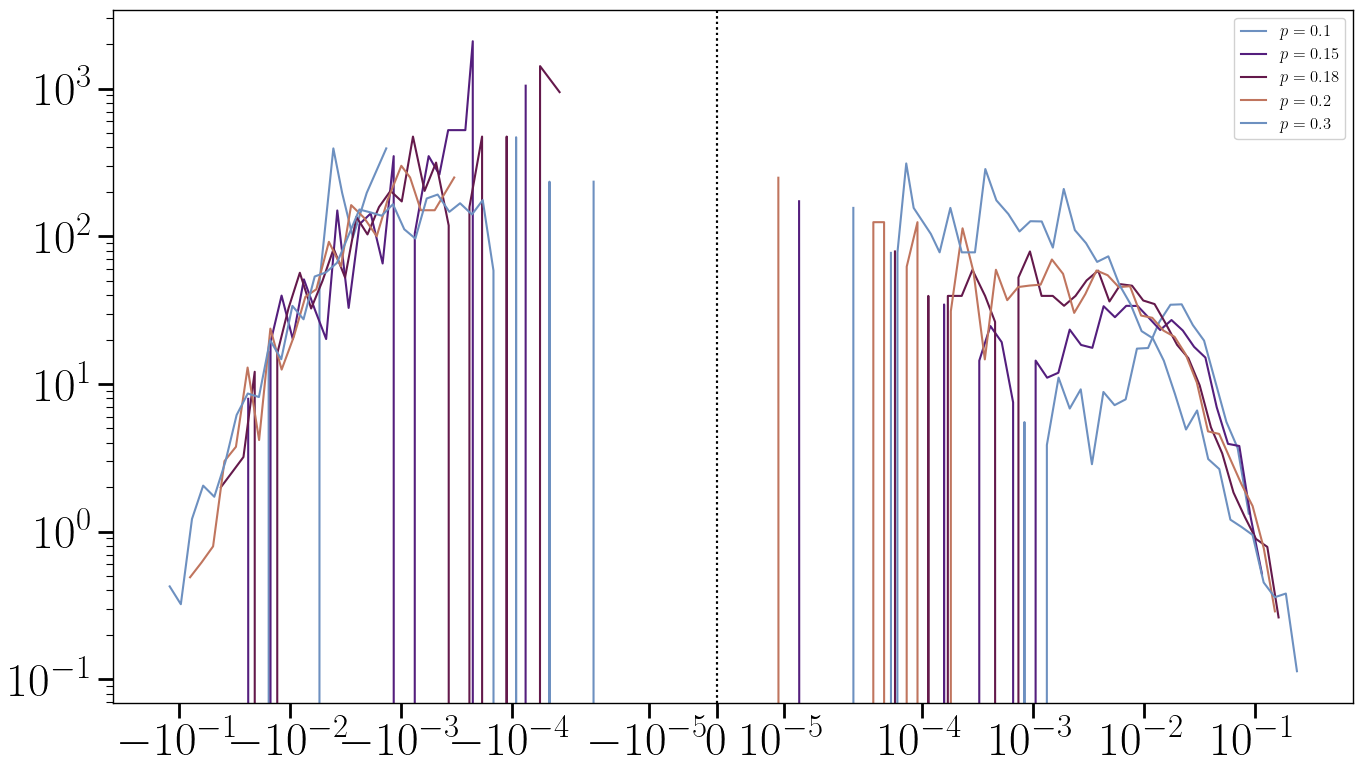

In [54]:
side = 10
for pflip in [0.1, 0.15, 0.18, 0.2, 0.3]:
    arrP = []
    arrM = []
    for _ in range(1):
        l = Lattice3D(side, pflip=pflip)
        l.flip_random_fract_edges()
        l.compute_k_eigvV()
        dat = flip_to_positive_majority_adapted(l.eigV[0].flatten())
        arrP.append(dat[dat>0])
        arrM.append(np.abs(dat[dat<0]))
    x, pdf = powerlaw.pdf(np.concatenate(arrP))
    line, = plt.plot(x[1:], pdf, label=fr"$p={pflip:.3g}$")
    x, pdf = powerlaw.pdf(np.concatenate(arrM))
    plt.plot(-x[1:], pdf, c=line.get_color())
plt.xscale('symlog', linthresh=np.min(x[1:]))
plt.yscale('log')
plt.legend()
plt.axvline(np.finfo(float).eps, **axvline_kwarg)
plt.axvline(-np.finfo(float).eps, **axvline_kwarg)
plt.show()

## Fig. (e): power law scaling at $p_{\rm c}$

### Cubic 3D

In [ ]:
L = [5, 10, 20, 30, 40, 50]
cell = 'rand'
fit_exponent = -2.18
p_pattern = re.compile(r'p=([0-9.]+)')
na_pattern = re.compile(r'na=([0-9]+)')
lrgpath = "data/cluster_data/l3d_simple_cubic/lrgsg/"
pattern = r"p=([\d.]+)"
p_values_shared_count = find_shared_p_values(pattern, lrgpath)

In [ ]:
for p,_ in p_values_shared_count:
    fig, ax = plt.subplots(figsize=(16.1, 10))
    for side in L:
        fpath = f"{lrgpath}N={side**3}/"
        listfname = os.listdir(fpath)
        for file_name in listfname:
            p_match = p_pattern.search(file_name)
            na_match = na_pattern.search(file_name)
            if p_match and na_match:
                na = int(na_match.group(1))
        fpath = f"{fpath}pCluster_p={p:.3g}_{cell}_na={na}.pkl"
        try:
            with open(fpath, 'rb') as file:
                data = pk.load(file)
        except:
            continue
        #
        sizes, counts = map(np.array, zip(*sorted(data.items())))
        data = np.repeat(sizes, counts)
        #
        fit1 = powerlaw.Fit(data, xmin=1, xmax=side**3, discrete=True, fit_method='KS')
        bins1, prob1 = fit1.pdf(linear_bins=False)
        bins1 = (bins1[1:]+bins1[:-1])/2.0
        prob1[prob1 == 0] = 'nan'
        #
        ax.plot(bins1, prob1, marker='', lw=2, label=f"{side}, {fit1.alpha:.3g}")
    ax.plot(bins1, prob1[0]*bins1**(fit_exponent), 'k--')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel(f"$P(S)$")
    ax.set_xlabel(f"$S$")
    ax.legend(title_fontsize = 13, title=f"$p={p:.3}$")
    fig.savefig(f"{datPthDict['pCluster']}l3dsc_p={p:.3g}_{cell}_na={na}.pdf", bbox_inches='tight')
    plt.close('all')

### Square 2D

In [ ]:
L = [16, 32, 64, 96, 128, 256]
cell = 'rand'
fit_exponent = -2.05
p_pattern = re.compile(r'p=([0-9.]+)')
na_pattern = re.compile(r'na=([0-9]+)')
lrgpath = "data/cluster_data/l2d_squared/lrgsg/"
pattern = r"p=([\d.]+)"
p_values_shared_count = find_shared_p_values(pattern, lrgpath)

In [ ]:
for p,_ in p_values_shared_count:
    fig, ax = plt.subplots(figsize=(16.1, 10))
    for side in L:
        fpath = f"{lrgpath}N={side**2}/"
        listfname = os.listdir(fpath)
        for file_name in listfname:
            p_match = p_pattern.search(file_name)
            na_match = na_pattern.search(file_name)
            if p_match and na_match:
                na = int(na_match.group(1))
        fpath = f"{fpath}pCluster_p={p:.3g}_{cell}_na={na}.pkl"
        try:
            with open(fpath, 'rb') as file:
                data = pk.load(file)
        except:
            continue
        #
        sizes, counts = map(np.array, zip(*sorted(data.items())))
        data = np.repeat(sizes, counts)
        #
        fit1 = powerlaw.Fit(data, xmin=1, xmax=side**2, discrete=True, fit_method='KS')
        bins1, prob1 = fit1.pdf(linear_bins=False)
        bins1 = (bins1[1:]+bins1[:-1])/2.0
        prob1[prob1 == 0] = 'nan'
        #
        ax.plot(bins1, prob1, marker='', lw=2, label=f"{side}, {fit1.alpha:.3g}")
    ax.plot(bins1, prob1[0]*bins1**(fit_exponent), 'k--')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel(f"$P(S)$")
    ax.set_xlabel(f"$S$")
    ax.legend(title_fontsize = 13, title=f"$p={p:.3}$")
    fig.savefig(f"{datPthDict['pCluster']}l2dsq_p={p:.3g}_{cell}_na={na}.pdf", bbox_inches='tight')
    plt.close('all')

## Fig. (b): Signed Random Walker

In [ ]:
seed = 0x7 % 0xFFFFFFFF
for p in [0.001, 0.01, 0.08, 0.1, 0.25, 0.4]:
    n_steps = int(10**3)
    fppath = f"{datPthDict['evolving_grid_rw']}nst={n_steps}_p={p:.3g}_seed={seed}.pdf"
    # if os.path.exists(fppath):
    #     continue
    fig, ax = plt.subplots(figsize=(8,8))
    np.random.seed(seed)
    plot_evolving_grid_rw(n_steps=n_steps, p = p, ax=ax,  col1=cred, col2=cblu, init = 'fixed')

    set_ax_ratio_1_withlim(ax)
    ax.set_aspect('equal')
    ax.set_axis_off()
    # plt.show()
    # radius = 0.45  # Circle's radius as defined in ax.transAxes coordinates
    # circle_center = (0.5, 0.5)  # Circle's center in ax.transAxes coordinates
    # Adding the circle to the figure with the specified radius and center
    # circle = Circle(circle_center, radius, lw=8, color='k', fill=False, transform=fig.transFigure, zorder=1)
    # fig.patches.append(circle)
    # # Text parameters
    # theta = 7/4 * np.pi  # Angle in radians for text placement
    # # Convert angle to degrees for text rotation, aligning text tangentially
    # angle_degrees = np.degrees(theta)
    # rotation = angle_degrees + 90
    # # Calculate text position using the circle's radius, placing text on the circumference
    # x_text = circle_center[0] + radius * np.cos(theta)
    # y_text = circle_center[1] + radius * np.sin(theta)
    # # Adding the text with specified properties, ensuring it's aligned with the circle's edge
    # fig.text(x_text, y_text, fr"$p={p:.3g}$", fontsize=42, ha='center', va='center',
    #         rotation=rotation, rotation_mode='anchor',
    #         bbox=dict(facecolor='white', alpha=1, edgecolor='none', boxstyle='round,pad=0.3'),
    #         transform=fig.transFigure, zorder=2) 
    fig.savefig(fppath, bbox_inches='tight')
    plt.close('all')

## Fig. (d): Phase transition

### Squared

#### Scaling Collapse

In [ ]:
L = [16, 23, 32, 45, 64]
#
fig, ax = plt.subplots(figsize=(6, 6))
axins = inset_axes(ax, width=2, height=2)
#
#
for cont, N in enumerate(L):
    perc = pd.read_csv(f"{datPthDict['Squared']}OrderP_L{N}",
                       sep=',', header=None)
    col = restr_twilight(cont/len(L))
    rc = perc[5][np.where(perc[3]==np.max(perc[3]))[0][0]]
    pinf, = ax.plot(((N)**(3/4))*(perc[5]-rc),((N)**(15/144))*gaussian_filter(perc[1],sigma=0),
            label=str(N*N), zorder=-cont,color=col,lw=2, marker='')
    chi_scaled = (N**(-129/72))*gaussian_filter(perc[3]*N*N,sigma=0)

    chiplot, = axins.plot((N**(3/4))*(perc[5]-rc), chi_scaled,
                          lw=2,zorder=-cont,color=col, marker='')
    print(N, rc)
axins.axvline(0, **axvline_kwarg)

ax.set_xlabel(r'$L^{(1/\nu)}(p-p_c)$')
ax.set_ylabel(r'$L^{\beta/\nu}P_\infty$')
axins.set_xlabel(r'$L^{(1/\nu)}(p-p_c)$', **xlabelinset_kwargs)
axins.set_ylabel(r'$L^{-\gamma/\nu}\chi$', **ylabelinset_kwargs)
axins.set_xbound([-2.25, 2.25])
axins.yaxis.set_major_locator(plt.MaxNLocator(3))
axins.tick_params(**axins_tickparams_kwargs)


ax.legend(**axlegend_kwargs)

fppath = f"{datPthDict['Squared']}/collapse_perc.pdf"
fig.savefig(fppath, bbox_inches='tight', transparent=True)

#### Order parameter

In [ ]:
L = [16,23,32,45,64]
#
fig, ax = plt.subplots(figsize=(6, 6))

axins = inset_axes(ax, width=1.75, height=1.75)
#
#
cmap_val = plt.cm.twilight(np.linspace(0.2, 0.8, len(L)))
custom_cmap = LinearSegmentedColormap.from_list("restr_twilight", cmap_val)
cmap =cm.get_cmap(custom_cmap, len(L))
pal = list(cmap_val)# [cmap(i) for i in range(len(L))]


for cont, N in enumerate(L):
    perc = pd.read_csv(f"{datPthDict['Squared']}OrderP_L{N}",
                       sep=',', header=None)
    c0 = pal.pop(0)
    ax.plot(perc[5],gaussian_filter(perc[1],sigma=1),label=str(N*N),
                     zorder=-cont,color=c0, marker='', lw=2)
    axins.plot(perc[5],gaussian_filter(perc[3]*N*N,sigma=1),zorder=-cont,color=c0, marker='', lw=2)

axins.axvline(x=0.103, **axvline_kwarg)

ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$P_\infty$')
axins.set_xlabel(r'$p$', **xlabelinset_kwargs)
axins.set_ylabel(r'$\chi$', **ylabelinset_kwargs)

axins.yaxis.set_major_locator(plt.MaxNLocator(3))
axins.tick_params(axis='both', which='major', size=7, width=1.25, labelsize=16)
ax.legend(ncol=1,loc='lower left', fontsize=18)


fppath = f"{datPthDict['Squared']}/transition.pdf"
fig.savefig(fppath, bbox_inches='tight', transparent=True)

### Triangular

#### Order parameter

In [ ]:
L = [20, 30, 40, 50, 60, 90]
#
fig, ax = plt.subplots(figsize=(6, 6))

axins = inset_axes(ax, width=1.75, height=1.75)
#
#
cmap_val = plt.cm.twilight(np.linspace(0.2, 0.8, len(L)))
custom_cmap = LinearSegmentedColormap.from_list("restr_twilight", cmap_val)
cmap =cm.get_cmap(custom_cmap, len(L))
pal = list(cmap_val)# [cmap(i) for i in range(len(L))]


for cont, N in enumerate(L):
    perc = pd.read_csv(f"{datPthDict['Triangular']}OrderP_L{N}",
                       sep=',', header=None)
    c0 = pal.pop(0)
    ax.plot(perc[5], ((N*N)/(0.5*N*(N+2)))*gaussian_filter(perc[1],sigma=1),label=str(int(0.5*N*(N+2))),
                     zorder=-cont,color=c0, marker='')
    axins.plot(perc[5],(((N*N)/(0.5*N*(N+2)))**2)*gaussian_filter(perc[3]*(0.5*N*(N+2)),sigma=1),zorder=-cont,color=c0, marker='')


critp = perc[5][np.argmax((((N*N)/(0.5*N*(N+2)))**2)*gaussian_filter(perc[3]*(0.5*N*(N+2)),sigma=1))]
axins.axvline(x=critp, **axvline_kwarg)

ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$P_\infty$')
axins.set_xlabel(r'$p$', **xlabelinset_kwargs)
axins.set_ylabel(r'$\chi$', **ylabelinset_kwargs)

axins.yaxis.set_major_locator(plt.MaxNLocator(3))
axins.tick_params(axis='both', which='major', size=7, width=1.25, labelsize=16)
ax.legend(ncol=1,loc='lower left', fontsize=18)


fppath = f"{datPthDict['Triangular']}/transition.pdf"
fig.savefig(fppath, bbox_inches='tight', transparent=True)

In [ ]:
L=[20,30,40,50,60,90]
L.reverse()
#
fig, ax = plt.subplots(figsize=(6, 6))

axins = inset_axes(ax, width=1.75, height=1.75)
#
#

pal = list(restr_twilight(np.linspace(0, 1, len(L))))# [cmap(i) for i in range(len(L))]

print(L)
for cont, N in enumerate(L):
    perc = pd.read_csv(f"{datPthDict['Triangular']}OrderP_L{N}",
                       sep=',', header=None)
    c0 = pal.pop(0)
    rc=perc[5][np.where(perc[3]==np.max(perc[3]))[0][0]]
    L1=np.sqrt(0.5*N*(N+2))
    ax.plot((N**(3/4))*(perc[5]-rc),((N)**(15/144))*((N*N)/(0.5*N*(N+2)))*gaussian_filter(perc[1],sigma=1),label=str(int(0.5*N*(N+2))),
                    zorder=-cont,color=c0,lw=1.5, marker='', lw=2)

    axins.plot((N**(3/4))*(perc[5]-rc),(N**(-129/72))*(((N*N)/(0.5*N*(N+2)))**2)*gaussian_filter(perc[3]*(0.5*N*(N+2)),sigma=1),lw=1.5,zorder=-cont,color=c0, marker='', lw=2)

critp = perc[5][np.argmax((((N*N)/(0.5*N*(N+2)))**2)*gaussian_filter(perc[3]*(0.5*N*(N+2)),sigma=1))]
axins.axvline(x=0, **axvline_kwarg)

ax.set_xlabel(r'$L^{(1/\nu)}(p-p_c)$')
ax.set_ylabel(r'$L^{\beta/\nu}P_\infty$')
axins.set_xlabel(r'$L^{(1/\nu)}(p-p_c)$', **xlabelinset_kwargs)
axins.set_ylabel(r'$L^{-\gamma/\nu}\chi$', **ylabelinset_kwargs)

axins.yaxis.set_major_locator(plt.MaxNLocator(3))
axins.tick_params(axis='both', which='major', size=7, width=1.25, labelsize=16)
ax.legend(ncol=1,loc='lower left', fontsize=18)


fppath = f"{datPthDict['Triangular']}/collapse_perc.pdf"
fig.savefig(fppath, bbox_inches='tight', transparent=True)




### 3D Order parameter

In [ ]:
L = [6, 8, 10, 13]
#
#
fig, ax = plt.subplots(figsize=(6, 6))

axins = inset_axes(ax, width=1.75, height=1.75)
#
#
cmap_val = plt.cm.twilight(np.linspace(0.2, 0.8, len(L)))
custom_cmap = LinearSegmentedColormap.from_list("restr_twilight", cmap_val)
cmap =cm.get_cmap(custom_cmap, len(L))
pal = list(cmap_val)# [cmap(i) for i in range(len(L))]


for cont, N in enumerate(L):
    perc = pd.read_csv(f"{datPthDict['3D']}OrderP_L{N}",
                       sep=',', header=None)
    c0 = pal.pop(0)
    ax.plot(perc[5],gaussian_filter(perc[1],sigma=1),label=str(N*N*N),
                     zorder=-cont,color=c0, marker='', lw=2)
    axins.plot(perc[5],gaussian_filter(perc[3]*N*N*N,sigma=1),zorder=-cont,color=c0, marker='', lw=2)

axins.axvline(x=0.222, **axvline_kwarg)

ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$P_\infty$')
axins.set_xlabel(r'$p$', **xlabelinset_kwargs)
axins.set_ylabel(r'$\chi$', **ylabelinset_kwargs)
axins.xaxis.set_major_locator(plt.MaxNLocator(3))

axins.yaxis.set_major_locator(plt.MaxNLocator(3))
axins.tick_params(axis='both', which='major', size=7, width=1.25, labelsize=16)
ax.legend(ncol=1,loc='lower left', fontsize=18)


fppath = f"{datPthDict['3D']}/transition.pdf"
fig.savefig(fppath, bbox_inches='tight', transparent=True)

In [ ]:
L = [6, 8, 10, 13]
L.reverse()
#
fig, ax = plt.subplots(figsize=(6, 6))

axins = inset_axes(ax, width=1.75, height=1.75)
#
#

pal = list(restr_twilight(np.linspace(0, 1, len(L))))# [cmap(i) for i in range(len(L))]

print(L)
for cont, N in enumerate(L):
    perc = pd.read_csv(f"{datPthDict['3D']}OrderP_L{N}",
                       sep=',', header=None)
    c0 = pal.pop(0)
    rc = perc[5][np.where(perc[3]==np.max(perc[3]))[0][0]]
    L1=np.sqrt(0.5*N*(N+2))
    ax.plot((N**(3/4))*(perc[5]-rc),((N)**(15/144))*((N*N)/(0.5*N*(N+2)))*gaussian_filter(perc[1],sigma=1),label=str(int(0.5*N*(N+2))),
                    zorder=-cont,color=c0,lw=1.5, marker='', lw=2)

    axins.plot((N**(3/4))*(perc[5]-rc),(N**(-129/72))*(((N*N)/(0.5*N*(N+2)))**2)*gaussian_filter(perc[3]*(0.5*N*(N+2)),sigma=1),lw=1.5,zorder=-cont,color=c0, marker='', lw=2)

critp = perc[5][np.argmax((((N*N)/(0.5*N*(N+2)))**2)*gaussian_filter(perc[3]*(0.5*N*(N+2)),sigma=1))]
axins.axvline(x=critp, **axvline_kwarg)

ax.set_xlabel(r'$L^{(1/\nu)}(p-p_c)$')
ax.set_ylabel(r'$L^{\beta/\nu}P_\infty$')
axins.set_xlabel(r'$L^{(1/\nu)}(p-p_c)$', **xlabelinset_kwargs)
axins.set_ylabel(r'$L^{-\gamma/\nu}\chi$', **ylabelinset_kwargs)

axins.yaxis.set_major_locator(plt.MaxNLocator(3))
axins.tick_params(axis='both', which='major', size=7, width=1.25, labelsize=16)
ax.legend(ncol=1,loc='lower left', fontsize=18)


fppath = f"{datPthDict['3D']}/collapse_perc.pdf"
fig.savefig(fppath, bbox_inches='tight', transparent=True)


### Hexagonal

In [ ]:
L = [12, 16, 22, 32, 46]
#
fig, ax = plt.subplots(figsize=(6, 6))

axins = inset_axes(ax, width=1.75, height=1.75)
#
#
cmap_val = plt.cm.twilight(np.linspace(0.2, 0.8, len(L)))
custom_cmap = LinearSegmentedColormap.from_list("restr_twilight", cmap_val)
cmap =cm.get_cmap(custom_cmap, len(L))
pal = list(cmap_val)# [cmap(i) for i in range(len(L))]


for cont, N in enumerate(L):
    perc = pd.read_csv(f"{datPthDict['Hexagonal']}OrderP_L{N}",
                       sep=',', header=None)
    c0 = pal.pop(0)
    ax.plot(perc[5],1/2*gaussian_filter(perc[1],sigma=1),label=str(N*N),
                     zorder=-cont,color=c0, marker='', lw=2)
    axins.plot(perc[5],1/4*gaussian_filter(perc[3]*2*N*N,sigma=1),zorder=-cont,color=c0, marker='', lw=2)

axins.axvline(x=0.065, **axvline_kwarg)

ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$P_\infty$')
axins.set_xlabel(r'$p$', **xlabelinset_kwargs)
axins.set_ylabel(r'$\chi$', **ylabelinset_kwargs)

axins.yaxis.set_major_locator(plt.MaxNLocator(3))
axins.tick_params(axis='both', which='major', size=7, width=1.25, labelsize=16)
ax.legend(ncol=1,loc='lower left', fontsize=18)


fppath = f"{datPthDict['Hexagonal']}/hex_transition.pdf"
fig.savefig(fppath, bbox_inches='tight', transparent=True)

In [ ]:
L = [12, 16, 22, 32, 46]
#
fig, ax = plt.subplots(figsize=(6, 6))

axins = inset_axes(ax, width=1.75, height=1.75)
#
#
cmap_val = plt.cm.twilight(np.linspace(0.2, 0.8, len(L)))
custom_cmap = LinearSegmentedColormap.from_list("restr_twilight", cmap_val)
cmap =cm.get_cmap(custom_cmap, len(L))
pal = list(cmap_val)# [cmap(i) for i in range(len(L))]


for cont, N in enumerate(L):
    perc = pd.read_csv(f"{datPthDict['Hexagonal']}OrderP_L{N}",
                       sep=',', header=None)
    c0 = pal.pop(0)
    rc=perc[5][np.where(perc[3]==np.max(perc[3]))[0][0]]
    L1=np.sqrt(0.5*N*(N+2))
    ax.plot((N**(3/4))*(perc[5]-rc),((N)**(15/144))*((N*N)/(0.5*N*(N)))*gaussian_filter(perc[1],sigma=1),label=str(int(0.5*N*(N))),
                    zorder=-cont,color=c0, marker='', lw=2)

    axins.plot((N**(3/4))*(perc[5]-rc),(N**(-129/72))*(((N*N)/(0.5*N*(N)))**2)*gaussian_filter(perc[3]*(0.5*N*(N)),sigma=1),zorder=-cont,color=c0, marker='', lw=2)

critp = perc[5][np.argmax((((N*N)/(0.5*N*(N)))**2)*gaussian_filter(perc[3]*(0.5*N*(N)),sigma=1))]
axins.axvline(x=0, **axvline_kwarg)



axins.axvline(x=0, **axvline_kwarg)

ax.set_xlabel(r'$L^{(1/\nu)}(p-p_c)$')
ax.set_ylabel(r'$L^{\beta/\nu}P_\infty$')
axins.set_xlabel(r'$L^{(1/\nu)}(p-p_c)$', **xlabelinset_kwargs)
axins.set_ylabel(r'$L^{-\gamma/\nu}\chi$', **ylabelinset_kwargs)

axins.yaxis.set_major_locator(plt.MaxNLocator(3))
axins.tick_params(axis='both', which='major', size=7, width=1.25, labelsize=16)
ax.legend(ncol=1,loc='lower left', fontsize=18)


fppath = f"{datPthDict['Hexagonal']}/hex_collapse_perc.pdf"
fig.savefig(fppath, bbox_inches='tight', transparent=True)

### Defects illustr.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib as mpl

def plot_square_lattice(
    ax,
    size: int = 7,
    kwargs_nodes: dict = dict(marker="o", ms=20, mec="k", mfc="w"),
    kwargs_extl: dict = dict(ls=":"),
    etxl_len: float = 0.75,
    kwargs_lines: dict = dict(lw=3),
    pec="blue",
    cpec="red",
):
    """
    Function to plot a square lattice where the color and style of each link
    can be controlled individually.
    """
    x, y = np.meshgrid(range(size), range(size))

    # Plot lines individually with control over color
    for i in range(size):
        for j in range(size):
            # Vertical lines
            if i < size - 1:
                line_color = determine_line_color(i, j, "vertical", pec, cpec)
                plot_line_with_style(ax, [x[i, j], x[i + 1, j]], [y[i, j], y[i + 1, j]], line_color, kwargs_lines, cpec)
            
            # Horizontal lines
            if j < size - 1:
                line_color = determine_line_color(i, j, "horizontal", pec, cpec)
                plot_line_with_style(ax, [x[i, j], x[i, j + 1]], [y[i, j], y[i, j + 1]], line_color, kwargs_lines, cpec)
            
            # Nodes
            ax.plot(x[i, j], y[i, j], zorder=2, **kwargs_nodes)
            ax.text(x[i, j], y[i, j], f'({x[i, j]}, {y[i, j]})', color='black', ha='right', va='bottom')

    # Add dashed lines on the boundaries with random colors
    add_boundary_lines(ax, size, x, y, etxl_len, kwargs_extl, pec, cpec)

    # Remove axes for a cleaner look
    ax.axis("off")

def determine_line_color(i, j, direction, pec, cpec):
    """
    Function to determine the color of a line based on its position and direction.
    Customize this function to set specific link colors.
    """
    # Example condition to set a specific link's color
    if direction == "vertical":
        if i == 1 and j == 4:
            return cpec
        if i == 0 and j == 3:
            return cpec
        return pec
    elif direction == "horizontal" and i == 2 and j == 2:
        return cpec
    else:
        return pec

def plot_line_with_style(ax, x_coords, y_coords, color, kwargs_lines, cpec):
    """
    Helper function to plot a line with a specific color and optional style.
    """
    kwargs_lines["color"] = color
    if color == cpec:
        with mpl.rc_context({'path.sketch': (5, 15, 1)}):
            ax.plot(x_coords, y_coords, zorder=1, **kwargs_lines)
    else:
        ax.plot(x_coords, y_coords, zorder=1, **kwargs_lines)

def add_boundary_lines(ax, size, x, y, etxl_len, kwargs_extl, pec, cpec):
    """
    Function to add dashed boundary lines around the lattice.
    """
    for i in range(size):
        boundary_color = random.choice([pec, cpec])
        kwargs_extl["color"] = boundary_color
        # Left and right boundaries
        ax.plot([x[i, 0], x[i, 0] - etxl_len], [y[i, 0], y[i, 0]], zorder=0, **kwargs_extl)
        ax.plot([x[i, -1], x[i, -1] + etxl_len], [y[i, -1], y[i, -1]], zorder=0, **kwargs_extl)

        # Top and bottom boundaries
        ax.plot([x[0, i], x[0, i]], [y[0, i], y[0, i] - etxl_len], zorder=0, **kwargs_extl)
        ax.plot([x[-1, i], x[-1, i]], [y[-1, i], y[-1, i] + etxl_len], zorder=0, **kwargs_extl)

fig, ax= plt.subplots(figsize=(6, 6))
ax.set_aspect('equal')
plot_square_lattice(ax, 5)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib as mpl

def plot_square_lattice(
    ax,
    size: int = 7,
    size2: int = 7,  # New argument for the second dimension
    kwargs_nodes: dict = dict(marker="o", ms=20, mec="k", mfc="w"),
    kwargs_extl: dict = dict(ls=":"),
    etxl_len: float = 0.75,
    kwargs_lines: dict = dict(lw=3),
    pec="blue",
    cpec="red",
    kwargs_text: dict = dict(fontsize=8, color='black', ha='right', va='bottom')
):
    """
    Function to plot a square lattice where the color and style of each link
    can be controlled individually.
    """
    x, y = np.meshgrid(range(size), range(size2))  # Adjusted for size2

    # Plot lines individually with control over color
    for i in range(size):
        for j in range(size2):  # Adjusted loop for size2
            # Vertical lines
            if i < size - 1:
                line_color = determine_line_color(i, j, "vertical", pec, cpec)
                plot_line_with_style(ax, [x[i, j], x[i + 1, j]], [y[i, j], y[i + 1, j]], line_color, kwargs_lines, cpec)
            
            # Horizontal lines
            if j < size2 - 1:  # Adjusted condition for size2
                line_color = determine_line_color(i, j, "horizontal", pec, cpec)
                plot_line_with_style(ax, [x[i, j], x[i, j + 1]], [y[i, j], y[i, j + 1]], line_color, kwargs_lines, cpec)
            
            # Nodes
            ax.plot(x[i, j], y[i, j], zorder=2, **kwargs_nodes)
            # Adjust text positioning and size
            ax.text(x[i, j] + 0.1, y[i, j] - 0.1, f'({x[i, j]}, {y[i, j]})', **kwargs_text)

    # Add dashed lines on the boundaries with random colors
    add_boundary_lines(ax, size, x, y, etxl_len, kwargs_extl, pec, cpec)

    # Remove axes for a cleaner look
    ax.axis("off")

# Include the other necessary function definitions here...

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')
plot_square_lattice(ax, size=5, size2=7)  # Example usage with different sizes


In [ ]:
# graph + inset
# # Create a more complex graph for demonstration
# G = nx.complete_graph(50)
# pos = nx.spring_layout(G)  # Generate positions of nodes through spring layout

# # Draw the main graph
# fig, main_ax = plt.subplots(figsize=(12, 8))
# nx.draw(G, pos, ax=main_ax, node_size=50, with_labels=False, edge_color='gray')
# limits=main_ax.axis('on') # turns on axis
# main_ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
# # Identify a subgraph to zoom into (for example, the first 5 nodes and their connections)
# # nodes_of_interest = list(G.nodes())[:20]
# # subgraph = G.subgraph(nodes_of_interest)
# # pos_subgraph = {node: pos[node] for node in nodes_of_interest}

# # Add an inset to the main plot showing a zoomed region
# # The parameters for add_axes are [left, bottom, width, height], all in figure fraction
# # zoom_ax = plt.axes([0.5, 0.5, 0.3, 0.3], facecolor='lightyellow')

# x1, x2, y1, y2 = 0.3, 0.5, -.5, .5
# zoom_ax = main_ax.inset_axes(
#     [0.4, 0.5, 0.3, 0.2],
#     xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
# nx.draw(G, pos, ax=zoom_ax, node_size=50, with_labels=False, edge_color='gray')
# limits=zoom_ax.axis('on') # turns on axis

# # zoom_circle = Circle((0.5, 0.5), 0.5, transform=zoom_ax.transAxes, color='none', ec='black', lw=1)
# # zoom_ax.add_patch(zoom_circle)
# # zoom_ax.set_clip_path(zoom_circle)


# plt.show()


In [ ]:
### code to produce a grid with specific defects and inset

# np.random.seed(0)
# random.seed(0)
# lattice = Lattice2D(6, pbc=False)
# merged_dict = {**lattice.neg_weights_dict.get_neg_weights_dict_h_cross(6), 
#                **lattice.neg_weights_dict.get_neg_weights_dict_h_square(21),
#                **{(9, 10): -1}}
# # nodelist = random.sample(list(lattice.H.nodes()), lattice.N//5)
# # merged_dict = {k: v 
# #     for d in (
# #         [lattice.neg_weights_dict.get_neg_weights_dict_h_cross(i) for i in nodelist[:lattice.N//3]] + 
# #         [lattice.neg_weights_dict.get_neg_weights_dict_h_square(i) for i in nodelist[lattice.N//3:2*lattice.N//3]] +
# #         [lattice.neg_weights_dict.get_neg_weights_dict_h_rann(i) for i in nodelist[2*lattice.N//3:]]) 
# #     for k, v in d.items()}  
# lattice.flip_sel_edges(merged_dict)
# lattice.compute_k_eigvV()
# numbers = set()
# for key in merged_dict.keys():
#     numbers.update(key)
# G = lattice.G
# G_edges_ww = G.edges(data='weight')
# edgecol = [col1 if e[2] > 0 else col2 for e in G_edges_ww]
# rotated_pos = {node: (y, -x) for (x, y), node in zip(lattice.posG.values(), G.nodes())}
# # nodecol = [col1 if i < 0 else col2 for i in lattice.eigV[0]]
# nodecol = 'w'
# fig, ax = plt.subplots(figsize=(8, 8))
# # Draw the graph with sketchy style for negative edges
# nx.draw(G, 
#             pos=rotated_pos, 
#             ax=ax,  
#             width=2,
#             edge_color=edgecol,  
#             node_size=80, 
#             with_labels=False,  
#             node_color=nodecol,  
#             edgecolors='black')  

# ax.set_aspect('equal')


# x1, x2, y1, y2 = 10, 15, -10, -15


# lattice = Lattice2D(5, pbc=False)

# nodelist = random.sample(list(lattice.H.nodes()), lattice.N//5)
# merged_dict = {k: v 
#     for d in (
#         [lattice.neg_weights_dict.get_neg_weights_dict_h_cross(i) for i in nodelist[:lattice.N//3]] + 
#         [lattice.neg_weights_dict.get_neg_weights_dict_h_square(i) for i in nodelist[lattice.N//3:2*lattice.N//3]] +
#         [lattice.neg_weights_dict.get_neg_weights_dict_h_rann(i) for i in nodelist[2*lattice.N//3:]]) 
#     for k, v in d.items()}  
# lattice.flip_sel_edges(merged_dict)
# lattice.compute_k_eigvV()
# numbers = set()
# for key in merged_dict.keys():
#     numbers.update(key)
# G = lattice.G
# G_edges_ww = G.edges(data='weight')
# edgecol = [col1 if e[2] > 0 else col2 for e in G_edges_ww]
# rotated_pos = {node: (y, -x) for (x, y), node in zip(lattice.posG.values(), G.nodes())}
# nodecol = [col1 if i < 0 else col2 for i in lattice.eigV[0]]

# zoom_ax = ax.inset_axes(
#     [0.5, 0.5, 0.4, 0.4],
#     xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])

# zoom_ax.set_aspect('equal')
# nx.draw(G, 
#             pos=rotated_pos, 
#             ax=zoom_ax,  
#             width=2,
#             edge_color=edgecol,  
#             node_size=100, 
#             with_labels=False,  
#             node_color=nodecol,  
#             edgecolors='black')  

# limits=ax.axis('on') # turns on axis
# ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

# limits=zoom_ax.axis('on') # turns on axis
# zoom_ax.set_xticks([]); zoom_ax.set_yticks([])

# # Identify a subgraph to zoom into (for example, the first 5 nodes and their connections)
# # nodes_of_interest = list(G.nodes())[:20]
# # subgraph = G.subgraph(nodes_of_interest)
# # pos_subgraph = {node: pos[node] for node in nodes_of_interest}

# # Add an inset to the main plot showing a zoomed region
# # The parameters for add_axes are [left, bottom, width, height], all in figure fraction
# # zoom_ax = plt.axes([0.5, 0.5, 0.3, 0.3], facecolor='lightyellow')

# x1, x2, y1, y2 = 0.3, 0.5, -.5, .5
# zoom_ax = main_ax.inset_axes(
#     [0.4, 0.5, 0.3, 0.2],
#     xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
# nx.draw(G, pos, ax=zoom_ax, node_size=50, with_labels=False, edge_color='gray')
# limits=zoom_ax.axis('on') # turns on axis


In [ ]:
avg = average_evolving_rw()

In [ ]:
plt.imshow(avg)
plt.colorbar(label='Average State')

In [ ]:
%matplotlib inline
#
from lrgsglib.core import *
#
move_to_rootf(print_tf=True)
plt.style.use('nb/nb_plotsheet.mplstyle')
#
datPth = "data/plot/paper/panel_2/"
figpathdat = f"{datPth}lattices/"
os.makedirs(figpathdat, exist_ok=True)

In [ ]:
# Parameters
n = 200 # Grid dimensions
p = 0.1  # Probability of a negative edge
steps = n*n  # Number of steps in each random walk
N = 500  # Number of random walks

# Create the grid graph with signed edges
lattice = Lattice2D(side1=n, pflip = p)
lattice.flip_random_fract_edges()
G = lattice.G

# Perform N random walks and get the final node states
node_states = perform_random_walks(G, steps, N)
fig, ax = plt.subplots()
# Visualize the final states of nodes
visualize_node_states(node_states, n, n, ax=ax)

In [ ]:

visualize_node_states(dict((key, np.sign(value)) for key, value in node_states.items()), n, n)


In [ ]:
with open("data/l2d_squared/lrgsg/N=1024/p=0.11_na=100_.pickle", 'rb') as file:
    loaded_data = pickle.load(file)
    
binc, hist, bw = log_binning(loaded_data, 10)

In [ ]:

for i in [128]:
    with open(f"data/l2d_squared_CLUSTER/lrgsg/N={i**2}/p=0.12_na=512_.pickle", 'rb') as file:
        loaded_data = pk.load(file)
    
    b,h, bw = log_binning(loaded_data, binnum=15)
    plt.plot(b, h/(bw * h.sum()), 'o-', ms=10)
plt.plot(b, 10*(h/(bw * h.sum()))[0]*b**-2.05, lw=5, ls='--', c='k')
plt.yscale('log')
plt.xscale('log')

In [ ]:
# Assuming log_binning function is defined and loaded_data is available
b, h, bw = log_binning(loaded_data, binnum=8)

# Calculate the CCDF
# Reverse the cumulative sum to start from the right, then normalize by the total count
ccdf = np.cumsum(h[::-1])[::-1] / h.sum()

# Plot the PDF (as you've done)
# plt.plot(b, h / (bw * h.sum()), 'o', ms=10, label='PDF')

# Plot the CCDF
plt.plot(b, ccdf, 's-', ms=10, label='CCDF')
plt.plot(b, 3*ccdf[0]*b**-(1), 's-', ms=10, label='$\propto s^{-1}$ scaling (pdf $\propto s^{-2}$)')
# Log scale for x-axis, if applicable
plt.xscale('log')

# Log scale for y-axis to better visualize CCDF on logarithmic scale
plt.yscale('log')

# Labeling
plt.xlabel('clustersize')
plt.ylabel('CCDF')
plt.legend()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the power-law distribution
alpha = -1.5  # Exponent
x_min = 1   # Minimum value
size = 10000  # Number of samples

# Generate power-law distribution
x = np.random.zipf(-alpha, size)  # Using Zipf's law as it's a type of power-law distribution

# Calculate and plot the PDF (histogram)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(x, bins=np.logspace(np.log10(x_min), np.log10(max(x)), 50), density=True, alpha=0.6, color='g')
plt.xscale('log')
plt.yscale('log')
plt.title('Power-law distribution PDF')
plt.xlabel('Value')
plt.ylabel('Probability density')

# Calculate and plot the CCDF
# Sorting data to calculate the CCDF
sorted_x = np.sort(x)
yvals = np.arange(len(sorted_x))/float(len(sorted_x)-1)
ccdf = 1 - yvals

plt.subplot(1, 2, 2)
plt.loglog(sorted_x, ccdf, 'b-')
plt.title('Complementary Cumulative Distribution Function (CCDF)')
plt.xlabel('Value')
plt.ylabel('CCDF')

plt.tight_layout()
plt.show()


In [ ]:
with open(f"data/l2d_squared_CLUSTER/lrgsg/N={4096}/p=0.12_na=512_.pickle", 'rb') as file:
        loaded_data = pk.load(file)

In [ ]:
min_exp, max_exp = np.log10(min(loaded_data)), np.log10(max(loaded_data))
num_bins = 5  # You can adjust this based on your specific needs
bin_edges = np.logspace(min_exp, max_exp, num_bins)
plt.hist(loaded_data, bins=bin_edges, edgecolor='k', alpha=0.7)
plt.yscale('log')
plt.xscale('log')
x = np.logspace(0, 5)
plt.plot(x, 10000*x**-2)

In [ ]:
b,h, bw = log_binning(loaded_data, binnum=10)
plt.plot(b, h/bw, 'o', ms=10)
plt.plot(b, 10*(h/bw)[0]*b**-2)
plt.yscale('log')
plt.xscale('log')

In [ ]:
plt.plot(binc, hist/bw, 'o-', ms=10)
plt.plot(binc, 200*(1.0*np.array(binc))**(-2.05))
plt.yscale("log")
plt.xscale("log")

In [ ]:
plt.imshow(lattice.bin_eigV().reshape(lattice.syshape))
plt.colorbar()